# Backtest Log Analysis
This notebook parses `backtest.log` to visualize the performance of the trading strategy.
It includes:
1. **Equity Curve**: Total Inventory Value vs. Cost.
2. **PnL Analysis**: Daily and Cumulative Net Profit.
3. **Item Performance**: Which items are performing best/worst.
4. **Drawdown Analysis**: Maximum drop from peak equity.

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime

# Configuration
LOG_FILE = "backtest.log"

# Setup Plotting Style
sns.set_theme(style="darkgrid")
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['font.sans-serif'] = ['SimHei'] # For Chinese characters if needed, or fallback
plt.rcParams['axes.unicode_minus'] = False

In [93]:
def parse_log_file(filepath):
    data = []
    current_date = None
    
    # Regex patterns
    date_pattern = re.compile(r"--- Daily Report: (\d{4}-\d{2}-\d{2}) ---")
    value_pattern = re.compile(r"Total Inventory Value:\s+([\d\.]+)")
    cost_pattern = re.compile(r"Total Cost:\s+([\d\.]+)")
    pnl_pattern = re.compile(r"Total Net Profit:\s+([-\d\.]+)")
    
    with open(filepath, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        
    entry = {}
    for line in lines:
        # Check for Date
        date_match = date_pattern.search(line)
        if date_match:
            if entry: # Save previous entry
                data.append(entry)
            entry = {'Date': datetime.strptime(date_match.group(1), "%Y-%m-%d")}
            continue
            
        if not entry:
            continue
            
        # Check for Metrics
        val_match = value_pattern.search(line)
        if val_match:
            entry['Total Value'] = float(val_match.group(1))
            
        cost_match = cost_pattern.search(line)
        if cost_match:
            entry['Total Cost'] = float(cost_match.group(1))
            
        pnl_match = pnl_pattern.search(line)
        if pnl_match:
            entry['Net Profit'] = float(pnl_match.group(1))
            
    if entry: # Append last entry
        data.append(entry)
        
    return pd.DataFrame(data)

# Parse Data
df = parse_log_file(LOG_FILE)
df.set_index('Date', inplace=True)
print(f"Loaded {len(df)} days of data.")
df.tail()

Loaded 40 days of data.


,Total Value,Total Cost,Net Profit
Date,,,
2025-12-16,5770.32,6176.02,-405.7
2025-12-17,5806.22,6176.02,-369.8
2025-12-18,5810.02,6176.02,-366.0
2025-12-19,5807.82,6176.02,-368.2
2025-12-20,5728.70,6054.80,-326.1


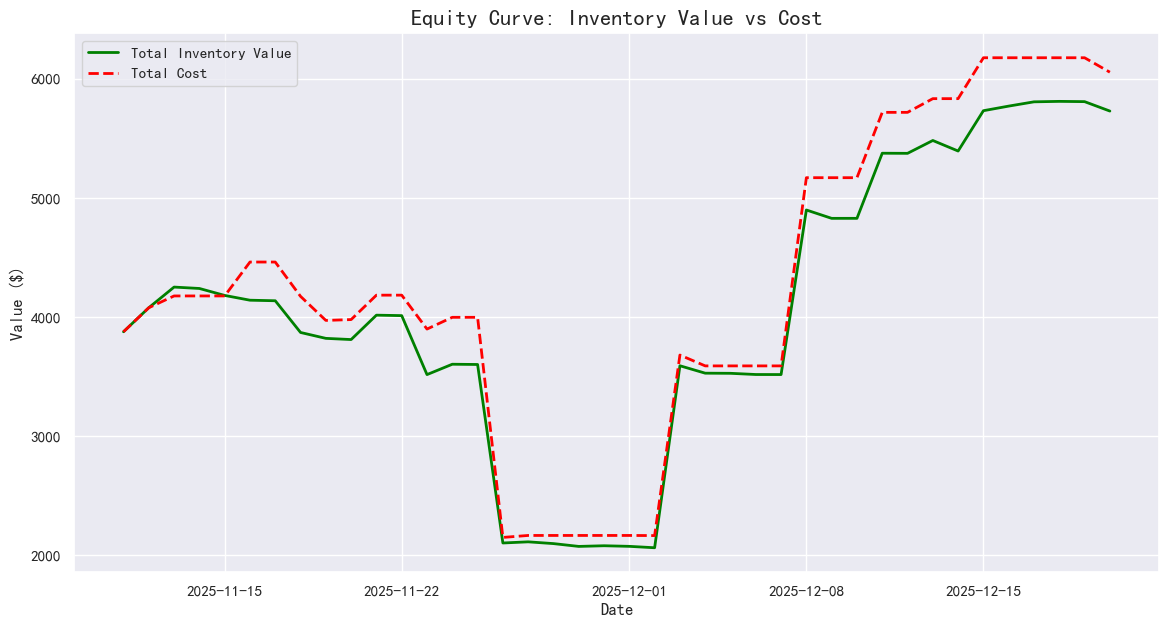

In [94]:
# 1. Equity Curve & Cost
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Total Value'], label='Total Inventory Value', color='green', linewidth=2)
plt.plot(df.index, df['Total Cost'], label='Total Cost', color='red', linestyle='--', linewidth=2)
plt.title('Equity Curve: Inventory Value vs Cost', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Value ($)')
plt.legend()
plt.show()

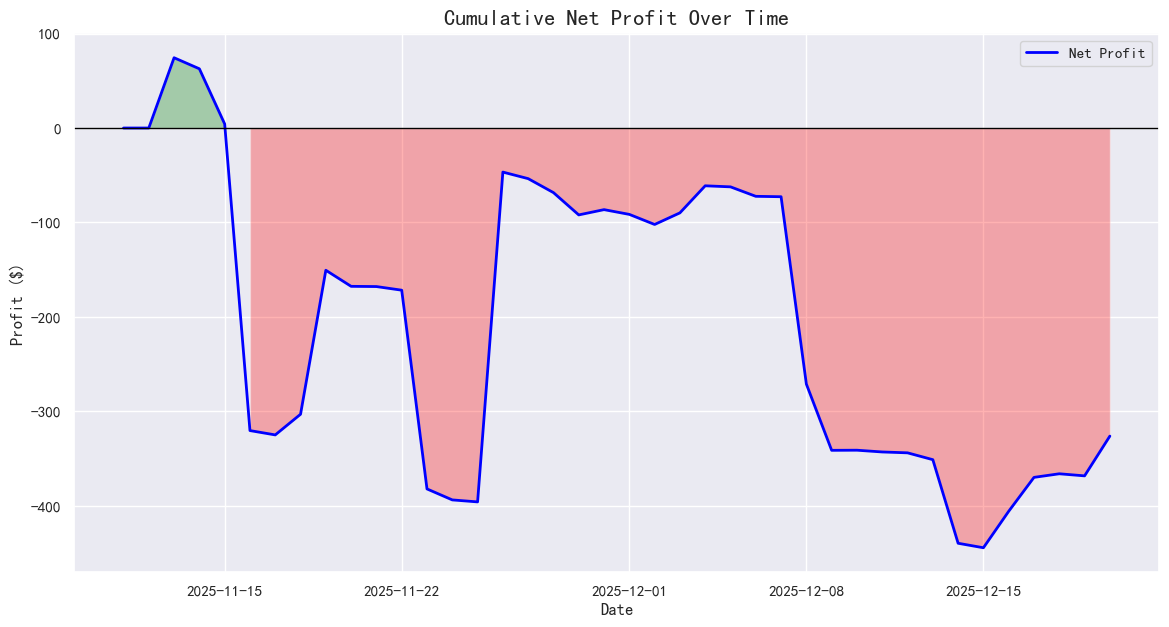

In [95]:
# 2. Net Profit Over Time
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Net Profit'], label='Net Profit', color='blue', linewidth=2)
plt.axhline(0, color='black', linewidth=1, linestyle='-')
plt.fill_between(df.index, df['Net Profit'], 0, where=(df['Net Profit'] >= 0), facecolor='green', alpha=0.3)
plt.fill_between(df.index, df['Net Profit'], 0, where=(df['Net Profit'] < 0), facecolor='red', alpha=0.3)
plt.title('Cumulative Net Profit Over Time', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Profit ($)')
plt.legend()
plt.show()

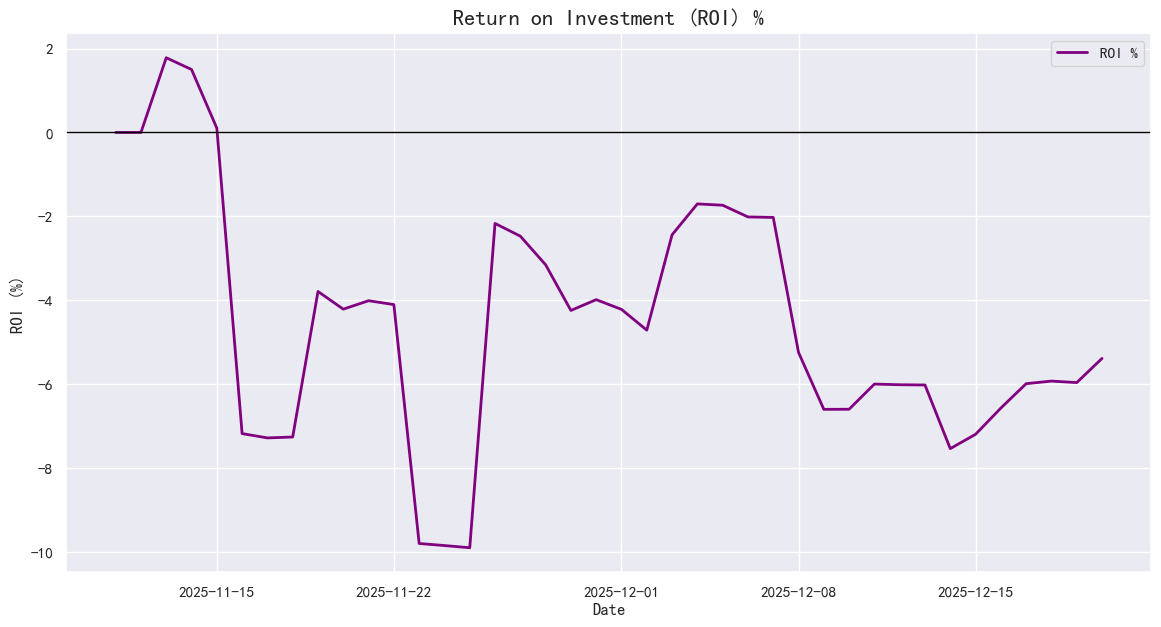

In [96]:
# 3. ROI %
df['ROI %'] = (df['Net Profit'] / df['Total Cost']) * 100

plt.figure(figsize=(14, 7))
plt.plot(df.index, df['ROI %'], label='ROI %', color='purple', linewidth=2)
plt.axhline(0, color='black', linewidth=1, linestyle='-')
plt.title('Return on Investment (ROI) %', fontsize=16)
plt.xlabel('Date')
plt.ylabel('ROI (%)')
plt.legend()
plt.show()

In [97]:
# 4. Summary Statistics
latest = df.iloc[-1]
max_profit = df['Net Profit'].max()
min_profit = df['Net Profit'].min()

print("=== Backtest Summary ===")
print(f"Start Date:       {df.index[0].strftime('%Y-%m-%d')}")
print(f"End Date:         {df.index[-1].strftime('%Y-%m-%d')}")
print(f"Duration:         {(df.index[-1] - df.index[0]).days} days")
print("-" * 30)
print(f"Final Inventory:  ${latest['Total Value']:.2f}")
print(f"Final Cost:       ${latest['Total Cost']:.2f}")
print(f"Final Net Profit: ${latest['Net Profit']:.2f}")
print(f"Final ROI:        {latest['ROI %']:.2f}%")
print("-" * 30)
print(f"Peak Profit:      ${max_profit:.2f}")
print(f"Max Drawdown:     ${min_profit:.2f}")

=== Backtest Summary ===
Start Date:       2025-11-11
End Date:         2025-12-20
Duration:         39 days
------------------------------
Final Inventory:  $5728.70
Final Cost:       $6054.80
Final Net Profit: $-326.10
Final ROI:        -5.39%
------------------------------
Peak Profit:      $74.38
Max Drawdown:     $-444.30


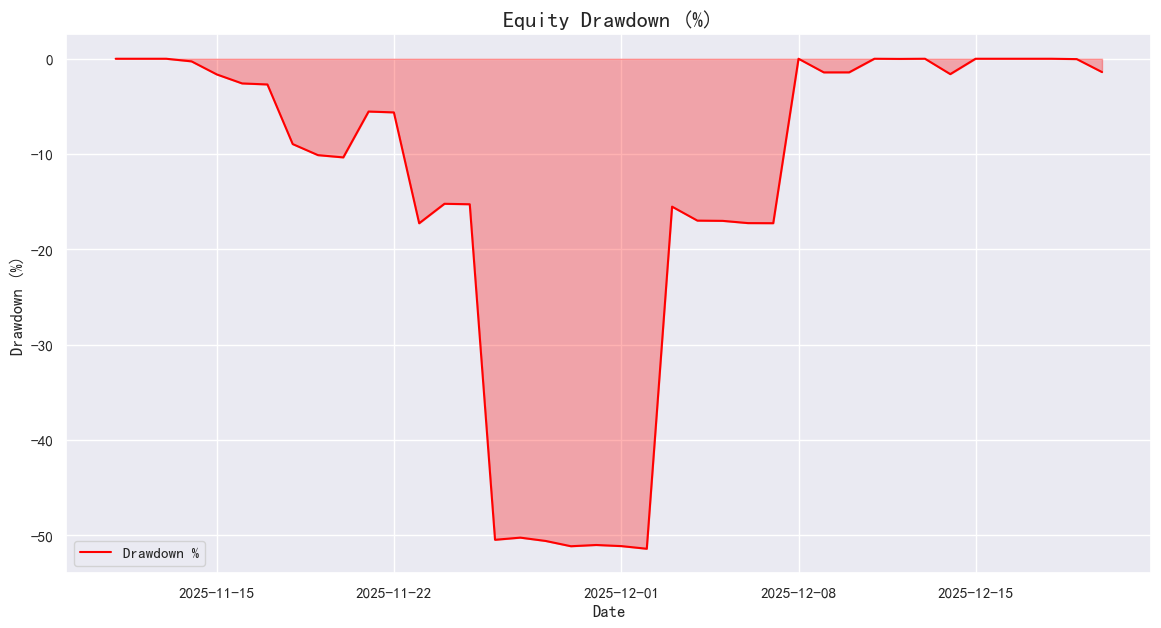

Max Drawdown: -51.44%


In [98]:
# 5. Drawdown Analysis
# Calculate Running Max of Total Value (Equity)
df['Peak Equity'] = df['Total Value'].cummax()
df['Drawdown'] = (df['Total Value'] - df['Peak Equity']) / df['Peak Equity'] * 100

plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Drawdown'], label='Drawdown %', color='red', linewidth=1.5)
plt.fill_between(df.index, df['Drawdown'], 0, color='red', alpha=0.3)
plt.title('Equity Drawdown (%)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Drawdown (%)')
plt.legend()
plt.show()

max_dd = df['Drawdown'].min()
print(f"Max Drawdown: {max_dd:.2f}%")

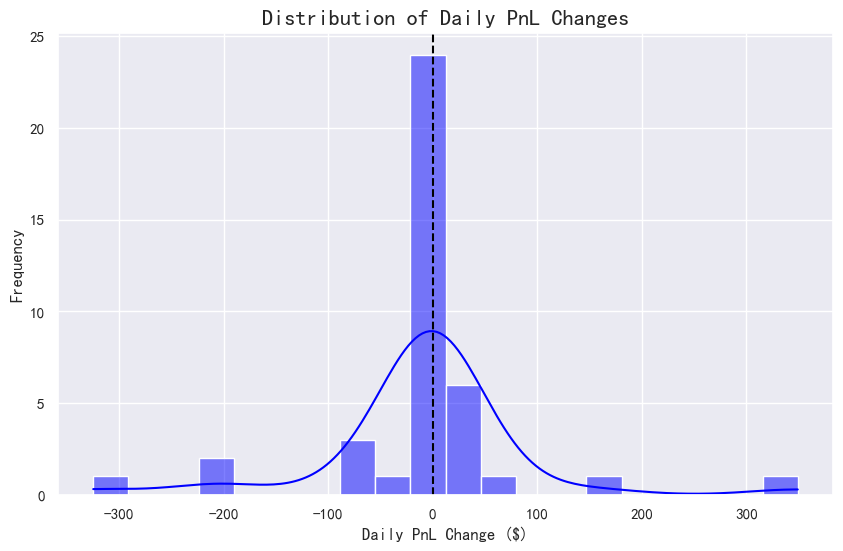

Average Daily PnL: $-8.15
Std Dev Daily PnL: $96.19
Win Rate (Days > 0): 30.00%


In [99]:
# 6. Daily PnL Distribution
df['Daily PnL Change'] = df['Net Profit'].diff().fillna(0)

plt.figure(figsize=(10, 6))
sns.histplot(df['Daily PnL Change'], kde=True, bins=20, color='blue')
plt.title('Distribution of Daily PnL Changes', fontsize=16)
plt.xlabel('Daily PnL Change ($)')
plt.ylabel('Frequency')
plt.axvline(0, color='black', linestyle='--')
plt.show()

print(f"Average Daily PnL: ${df['Daily PnL Change'].mean():.2f}")
print(f"Std Dev Daily PnL: ${df['Daily PnL Change'].std():.2f}")
win_rate = (df['Daily PnL Change'] > 0).mean() * 100
print(f"Win Rate (Days > 0): {win_rate:.2f}%")

Item Performance as of 2025-12-20


C:\Users\lenovo\AppData\Local\Temp\ipykernel_23056\1414228479.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=latest_items, y='Item', x='PnL %', palette='RdYlGn')


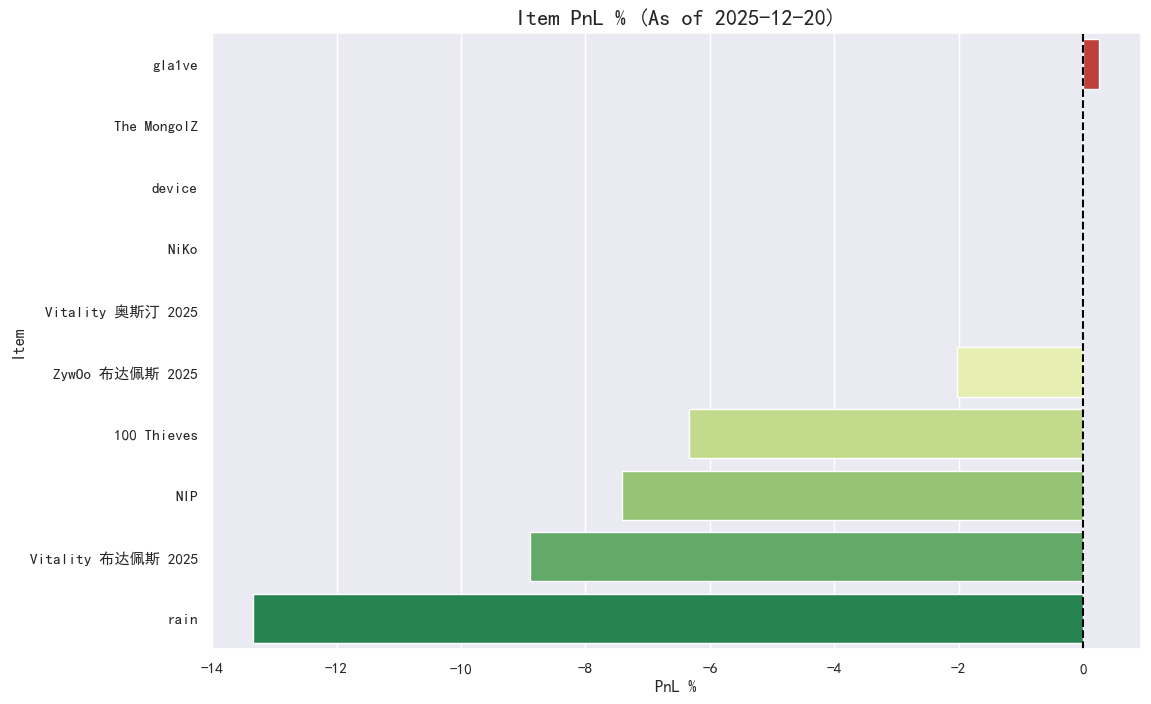

,Item,Price,PnL %
369,gla1ve,198.00,0.25
367,The MongolZ,0.02,0.00
371,device,600.00,0.00
370,NiKo,1580.00,0.00
375,Vitality 奥斯汀 2025,18.78,0.00
373,ZywOo 布达佩斯 2025,289.00,-2.03
366,100 Thieves,1629.00,-6.33
372,NIP,35.00,-7.41
374,Vitality 布达佩斯 2025,79.90,-8.89
368,rain,1299.00,-13.34


In [100]:
# 7. Item-Level Performance Analysis
def parse_item_performance(filepath):
    item_data = []
    current_date = None
    
    # Regex for item lines: "Item Name | Price | PnL %"
    # Example: "100 Thieves | 1659.00 | -4.60%"
    # Note: The log format uses fixed width or pipe separators.
    # Based on log: "15:29:42 | INFO | 100 Thieves | 1659.00 | -4.60%"
    
    item_pattern = re.compile(r"INFO\s+\|\s+(.*?)\s+\|\s+([\d\.]+)\s+\|\s+([-\+\d\.]+)%")
    date_pattern = re.compile(r"--- Daily Report: (\d{4}-\d{2}-\d{2}) ---")
    
    with open(filepath, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        
    for line in lines:
        # Update Date
        date_match = date_pattern.search(line)
        if date_match:
            current_date = datetime.strptime(date_match.group(1), "%Y-%m-%d")
            continue
            
        if current_date:
            # Check for Item Line
            match = item_pattern.search(line)
            if match:
                name = match.group(1).strip()
                price = float(match.group(2))
                pnl_pct = float(match.group(3))
                
                # Filter out header lines or separators if regex matches them by accident
                if "Item" in name or "---" in name:
                    continue
                    
                item_data.append({
                    'Date': current_date,
                    'Item': name,
                    'Price': price,
                    'PnL %': pnl_pct
                })
                
    return pd.DataFrame(item_data)

df_items = parse_item_performance(LOG_FILE)

if not df_items.empty:
    # Get latest snapshot
    latest_date = df_items['Date'].max()
    latest_items = df_items[df_items['Date'] == latest_date].sort_values('PnL %', ascending=False)
    
    print(f"Item Performance as of {latest_date.strftime('%Y-%m-%d')}")
    
    plt.figure(figsize=(12, 8))
    sns.barplot(data=latest_items, y='Item', x='PnL %', palette='RdYlGn')
    plt.title(f'Item PnL % (As of {latest_date.strftime("%Y-%m-%d")})', fontsize=16)
    plt.xlabel('PnL %')
    plt.axvline(0, color='black', linestyle='--')
    plt.show()
    
    display(latest_items[['Item', 'Price', 'PnL %']])
else:
    print("No item data found. Check log format regex.")

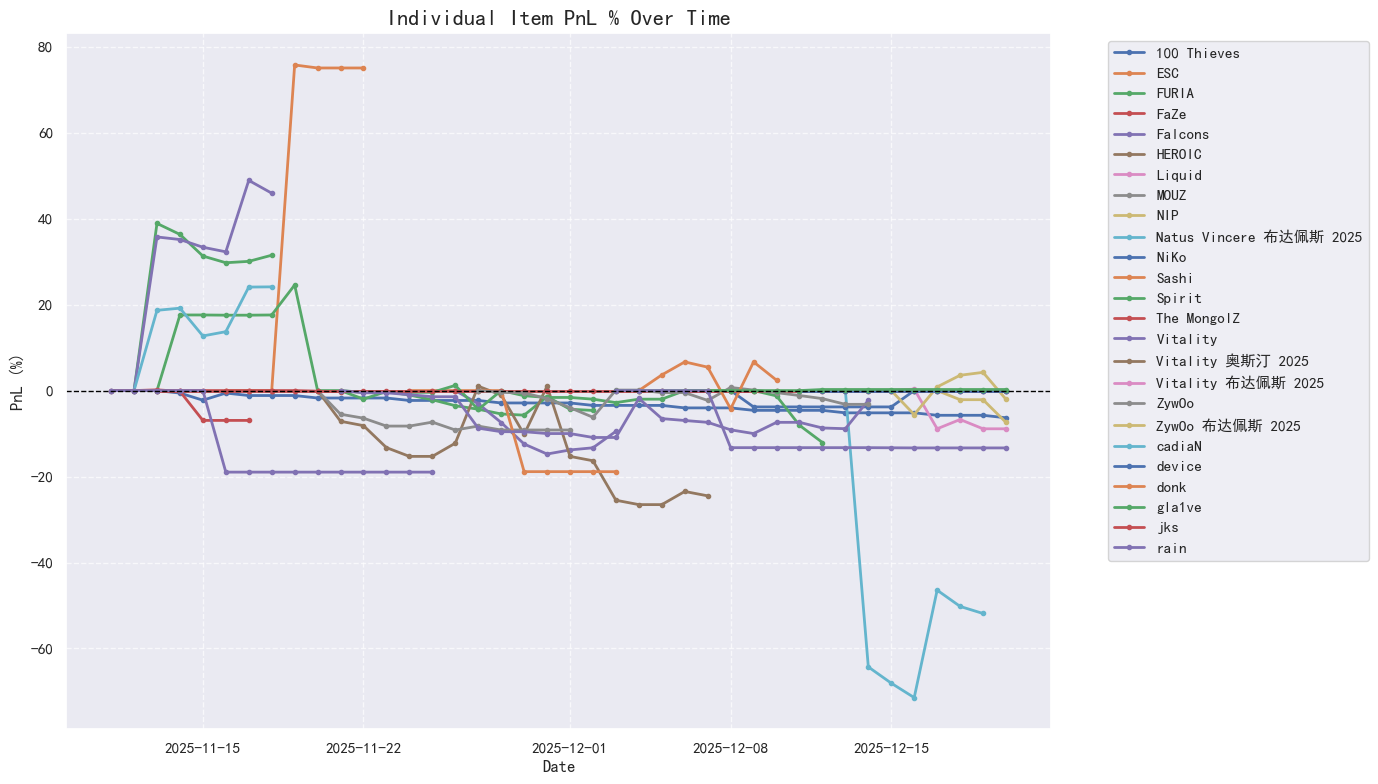

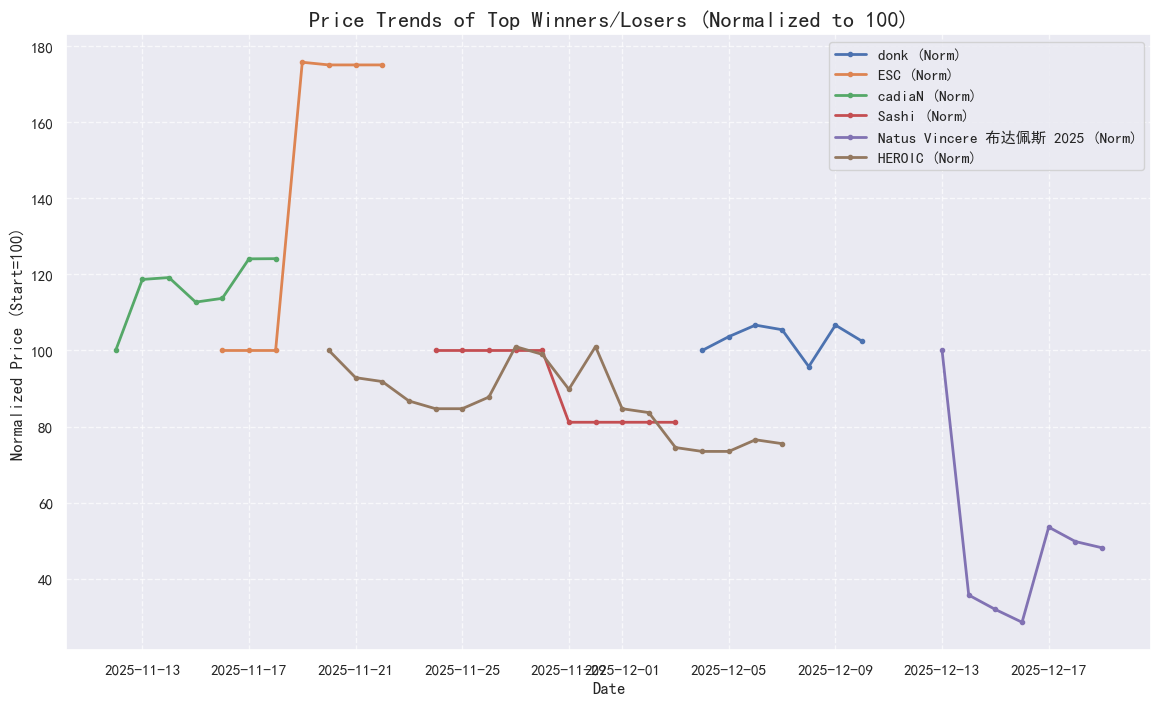

In [101]:
# 7.1 Individual Item PnL Curves
if not df_items.empty:
    # Pivot data to get PnL % time series for each item
    pnl_pivot = df_items.pivot(index='Date', columns='Item', values='PnL %')
    
    # Plot 1: PnL %
    plt.figure(figsize=(14, 8))
    
    # Plot each item
    for column in pnl_pivot.columns:
        # Use marker='.' to show points even if lines are broken (e.g. single day holdings)
        plt.plot(pnl_pivot.index, pnl_pivot[column], label=column, linewidth=2, marker='.')
        
    plt.title('Individual Item PnL % Over Time', fontsize=16)
    plt.xlabel('Date')
    plt.ylabel('PnL (%)')
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Legend outside plot
    plt.grid(True, which='both', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # Plot 2: Price Trends (Normalized)
    price_pivot = df_items.pivot(index='Date', columns='Item', values='Price')
    
    # Select top 3 winners and bottom 3 losers to plot prices
    # We use the last available PnL for sorting
    latest_pnl = pnl_pivot.ffill().iloc[-1].sort_values()
    interesting_items = list(latest_pnl.head(3).index) + list(latest_pnl.tail(3).index)
    interesting_items = list(set(interesting_items)) # Remove duplicates
    
    plt.figure(figsize=(14, 8))
    for item in interesting_items:
        if item in price_pivot.columns:
            series = price_pivot[item]
            # Find first valid index to normalize
            first_valid = series.first_valid_index()
            if first_valid is not None:
                base_price = series.loc[first_valid]
                if base_price > 0:
                    normalized_price = (series / base_price) * 100
                    plt.plot(price_pivot.index, normalized_price, label=f"{item} (Norm)", linewidth=2, marker='.')
            
    plt.title('Price Trends of Top Winners/Losers (Normalized to 100)', fontsize=16)
    plt.xlabel('Date')
    plt.ylabel('Normalized Price (Start=100)')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', alpha=0.7)
    plt.show()

C:\Users\lenovo\AppData\Local\Temp\ipykernel_23056\3146640944.py:10: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  item_daily_ret = price_pivot.pct_change()


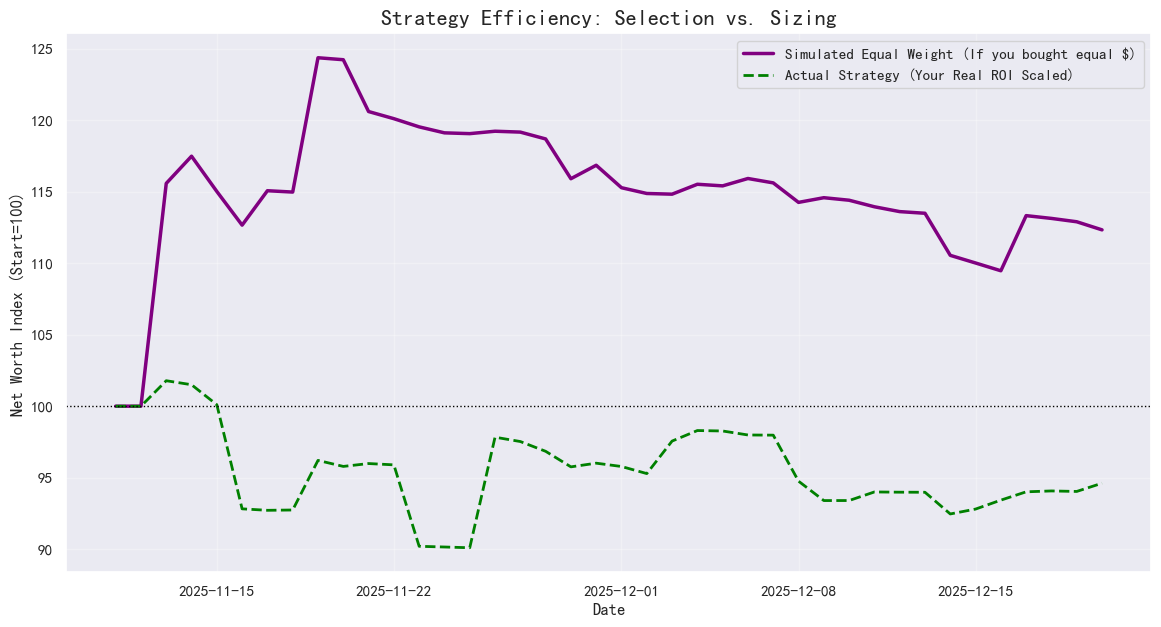

=== Simulation Results ===
Actual Strategy Final Index:      94.61 (-5.39%)
Equal Weight Strategy Final Index: 112.33 (12.33%)

[结论]: 你的选品眼光(紫色) 比 你的实际操作(绿色) 要好。
这意味着：你选到了一些好东西，但你买得太少；而你亏钱的东西，你买得太多了。


In [102]:
# 8. Counterfactual Analysis: Equal Weighted Portfolio (CORRECTED)
# Hypothesis: The strategy failed because it held too much of the losing items.
# Comparison: 
# - Purple Line: Simulated Index (If you put equal $ into every item).
# - Green Line: Actual ROI Scaled (Your actual performance per $1 invested).

if not df_items.empty:
    # 1. Calculate Daily Returns for each item
    price_pivot = df_items.pivot(index='Date', columns='Item', values='Price')
    item_daily_ret = price_pivot.pct_change()

    # 2. Calculate Equal Weighted Daily Return (Average of all active items' returns)
    ew_index_ret = item_daily_ret.mean(axis=1).fillna(0)

    # 3. Calculate Cumulative Return Index (Starting at 100)
    ew_equity_curve = (1 + ew_index_ret).cumprod() * 100

    # 4. Calculate Actual Strategy Performance Index
    # Formula: (Total Value / Total Cost) * 100
    # This represents: For every $100 spent, how much is it worth now?
    # If ROI is -5%, this value is 95.
    actual_curve = (df['Total Value'] / df['Total Cost']) * 100
    
    # Align dates
    common_dates = ew_equity_curve.index.intersection(actual_curve.index)
    
    if not common_dates.empty:
        ew_equity_curve = ew_equity_curve.loc[common_dates]
        actual_curve = actual_curve.loc[common_dates]
        
        # Re-base Equal Weight curve to match Actual curve start point for fair comparison
        # (Or just start both at 100 if we assume day 0 is par)
        # Let's start both at 100 for clarity.
        ew_equity_curve = ew_equity_curve / ew_equity_curve.iloc[0] * 100
        actual_curve = actual_curve / actual_curve.iloc[0] * 100

        plt.figure(figsize=(14, 7))
        plt.plot(ew_equity_curve.index, ew_equity_curve, label='Simulated Equal Weight (If you bought equal $)', color='purple', linewidth=2.5)
        plt.plot(actual_curve.index, actual_curve, label='Actual Strategy (Your Real ROI Scaled)', color='green', linestyle='--', linewidth=2)
        
        plt.title('Strategy Efficiency: Selection vs. Sizing', fontsize=16)
        plt.xlabel('Date')
        plt.ylabel('Net Worth Index (Start=100)')
        plt.legend()
        plt.axhline(100, color='black', linestyle=':', linewidth=1)
        plt.grid(True, alpha=0.3)
        plt.show()

        # Stats
        final_ew = ew_equity_curve.iloc[-1]
        final_actual = actual_curve.iloc[-1]
        
        print(f"=== Simulation Results ===")
        print(f"Actual Strategy Final Index:      {final_actual:.2f} ({(final_actual-100):.2f}%)")
        print(f"Equal Weight Strategy Final Index: {final_ew:.2f} ({(final_ew-100):.2f}%)")
        
        if final_ew > final_actual:
            print("\n[结论]: 你的选品眼光(紫色) 比 你的实际操作(绿色) 要好。")
            print("这意味着：你选到了一些好东西，但你买得太少；而你亏钱的东西，你买得太多了。")
        else:
            print("\n[结论]: 你的选品眼光(紫色) 和 实际操作(绿色) 一样烂，或者更差。")
            print("这意味着：核心问题在于 AI 选出来的东西本身就在跌，怎么买都是亏。")
    else:
        print("Not enough overlapping data for comparison.")